# Sentiment Analysis of F1 racing

# Data Collection

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
from PIL import Image
from datetime import datetime as dt
import nest_asyncio
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling
from wordcloud import WordCloud
%matplotlib inline


analyzer = SentimentIntensityAnalyzer()
nest_asyncio.apply()

In [ ]:
#if you have developer access to pull data from twitter follow the below code to extract the data after setting env variables for key and secret, I have used a altered datset from kaggle
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

search_query = "f1 2022 car"
lang = "en"

tweets = tweepy.Cursor(api.search, q=search_query, lang=lang).items()

# Save tweets to a CSV file
csv_file = open('F1_tweets.csv', 'w', encoding='utf-8', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(["Tweet", "Username", "Date"])

for tweet in tweets:
    csv_writer.writerow([tweet.text, tweet.user.screen_name, tweet.created_at])

csv_file.close()

In [36]:
# store in a pandas dataframe
#datset has been modified to have only the recent tweets from 2022
df_main = pd.read_csv("F1_tweets.csv")
df = df_main #to avoid re-reading data in case of issues, once finalised this can be removed
#ignore warning as the dataset will be cleaned after exploration

C:\Users\anizy\AppData\Local\Temp\ipykernel_8816\3610631622.py:3: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_main = pd.read_csv("F1_tweets.csv")


In [37]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,Link ➡️https://t.co/WpePiMd8qs,29/10/2021 05:43,0,2,4,FALSE,07/11/2021 15:21,Mexico City Grand Prix 2021 - F1 Race\r#Mexico...,"['MexicoGP', 'F1']",Twitter for Android,FALSE,NaN,NaN
1,#TeamPsg,11/02/2012 20:32,372,335,12710,FALSE,08/11/2021 15:40,Its race week again #F1,['F1'],Twitter for Android,FALSE,NaN,NaN
2,toutes les batailles que le temps me force jo...,24/08/2009 08:20,158,57,217,FALSE,14/01/2022 09:33,Precisely! #F1 https://t.co/HzNAMRzrnF,['F1'],Twitter for Android,FALSE,NaN,NaN
3,Arsenal FC,01/04/2011 10:54,632,672,4909,FALSE,21/11/2021 15:33,Well done @alo_oficial 💙 #F1 #QatarGP,"['F1', 'QatarGP']",Twitter for iPhone,FALSE,NaN,NaN
4,PA Limited Late Models,Central PA,Covering Pennsylvania Limited Late Models,27/03/2021 18:29,167,80,379,FALSE,20/08/2022 23:59,#F1 DJ Myers wins @rockitpizzasubs Carl Billet...,"['F1', 'CreeksideAutoSales']",Twitter Web App,False


In [38]:
df["text"]

0                                       Twitter for Android
1                                       Twitter for Android
2                                       Twitter for Android
3                                        Twitter for iPhone
4         #F1 DJ Myers wins @rockitpizzasubs Carl Billet...
                                ...                        
131361    This is very interesting. Mclaren Audi and Red...
131362    The patronizing message coming from (some) #F1...
131363    If you could bring back any F1 teammate pairin...
131364    The #f1 championship has never been such a mut...
131365    Maybe one day together at @ScuderiaFerrari?\n@...
Name: text, Length: 131366, dtype: object

# Exploratory Data Analysis 

In [39]:
# set columns that are relevant
relevant_col = [ 'date',  'user_name','text']
df = df[relevant_col]

In [40]:
df.head()

,date,user_name,text
0,"['MexicoGP', 'F1']",Link ➡️https://t.co/WpePiMd8qs,Twitter for Android
1,['F1'],#TeamPsg,Twitter for Android
2,['F1'],toutes les batailles que le temps me force jo...,Twitter for Android
3,"['F1', 'QatarGP']",Arsenal FC,Twitter for iPhone
4,20/08/2022 23:59,PA Limited Late Models,#F1 DJ Myers wins @rockitpizzasubs Carl Billet...


In [41]:
df.isnull().sum()

date         0
user_name    0
text         0
dtype: int64

In [46]:
df.duplicated().sum()

0

In [43]:
df.count()

date         131065
user_name    131065
text         131065
dtype: int64

# Data Pre-Processing

In [45]:
# check basic info on dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131065 entries, 0 to 131365
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   date       131065 non-null  object
 1   user_name  131065 non-null  object
 2   text       131065 non-null  object
dtypes: object(3)
memory usage: 4.0+ MB


In [42]:
# drop some duplicate tweets likely due to sponsored tweets
df.drop_duplicates(subset = "text", inplace = True)

In [47]:
df.shape

(131065, 3)

In [48]:
df.describe()

,date,user_name,text
count,131065,131065,131065
unique,38486,33196,131065
top,03/07/2022 16:23,F1reader,Twitter for Android
freq,616,2608,1


In [49]:
df["text"].describe()

count                  131065
unique                 131065
top       Twitter for Android
freq                        1
Name: text, dtype: object

In [50]:
df["user_name"].describe()

count       131065
unique       33196
top       F1reader
freq          2608
Name: user_name, dtype: object

In [51]:
df["date"].describe()

count               131065
unique               38486
top       03/07/2022 16:23
freq                   616
Name: date, dtype: object

In [52]:
df.head()

,date,user_name,text
0,"['MexicoGP', 'F1']",Link ➡️https://t.co/WpePiMd8qs,Twitter for Android
3,"['F1', 'QatarGP']",Arsenal FC,Twitter for iPhone
4,20/08/2022 23:59,PA Limited Late Models,#F1 DJ Myers wins @rockitpizzasubs Carl Billet...
5,20/08/2022 23:58,FormulaMarket,Not sure what I was expecting but y’all are go...
6,20/08/2022 23:56,Philip Patston,#INDYCAR are just toy #f1 so it’s not very eng...


In [53]:
#as we can see,  there are incorrect date format in date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

In [54]:
df.shape

(131063, 3)

In [55]:
# generate sentiment scores per tweet
sentiment_score = df["text"].apply(lambda x: analyzer.polarity_scores(x))

# add sentiment score to dataframe
df = pd.concat([df, sentiment_score.apply(pd.Series)],1)

C:\Users\anizy\AppData\Local\Temp\ipykernel_8816\354690231.py:5: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pd.concat([df, sentiment_score.apply(pd.Series)],1)


In [56]:
df.head()

,date,user_name,text,neg,neu,pos,compound
4,2022-08-20 23:59:00,PA Limited Late Models,#F1 DJ Myers wins @rockitpizzasubs Carl Billet...,0.047,0.817,0.136,0.5574
5,2022-08-20 23:58:00,FormulaMarket,Not sure what I was expecting but y’all are go...,0.081,0.919,0.000,-0.1957
6,2022-08-20 23:56:00,Philip Patston,#INDYCAR are just toy #f1 so it’s not very eng...,0.266,0.734,0.000,-0.5742
7,2022-08-20 23:53:00,Matt,@FDSportsbook Fanduel is the biggest scam. The...,0.159,0.656,0.184,0.2023
8,2022-08-20 23:52:00,FormulaRapida.net 🇬🇧 🇺🇸,Formula 1 drivers reflect on how the 2022 new ...,0.060,0.940,0.000,-0.1531


In [58]:
df["year_month"] = pd.to_datetime(df["date"]).dt.to_period("M")

In [59]:
df.head()

,date,user_name,text,neg,neu,pos,compound,year_month
4,2022-08-20 23:59:00,PA Limited Late Models,#F1 DJ Myers wins @rockitpizzasubs Carl Billet...,0.047,0.817,0.136,0.5574,2022-08
5,2022-08-20 23:58:00,FormulaMarket,Not sure what I was expecting but y’all are go...,0.081,0.919,0.000,-0.1957,2022-08
6,2022-08-20 23:56:00,Philip Patston,#INDYCAR are just toy #f1 so it’s not very eng...,0.266,0.734,0.000,-0.5742,2022-08
7,2022-08-20 23:53:00,Matt,@FDSportsbook Fanduel is the biggest scam. The...,0.159,0.656,0.184,0.2023,2022-08
8,2022-08-20 23:52:00,FormulaRapida.net 🇬🇧 🇺🇸,Formula 1 drivers reflect on how the 2022 new ...,0.060,0.940,0.000,-0.1531,2022-08


<AxesSubplot:>

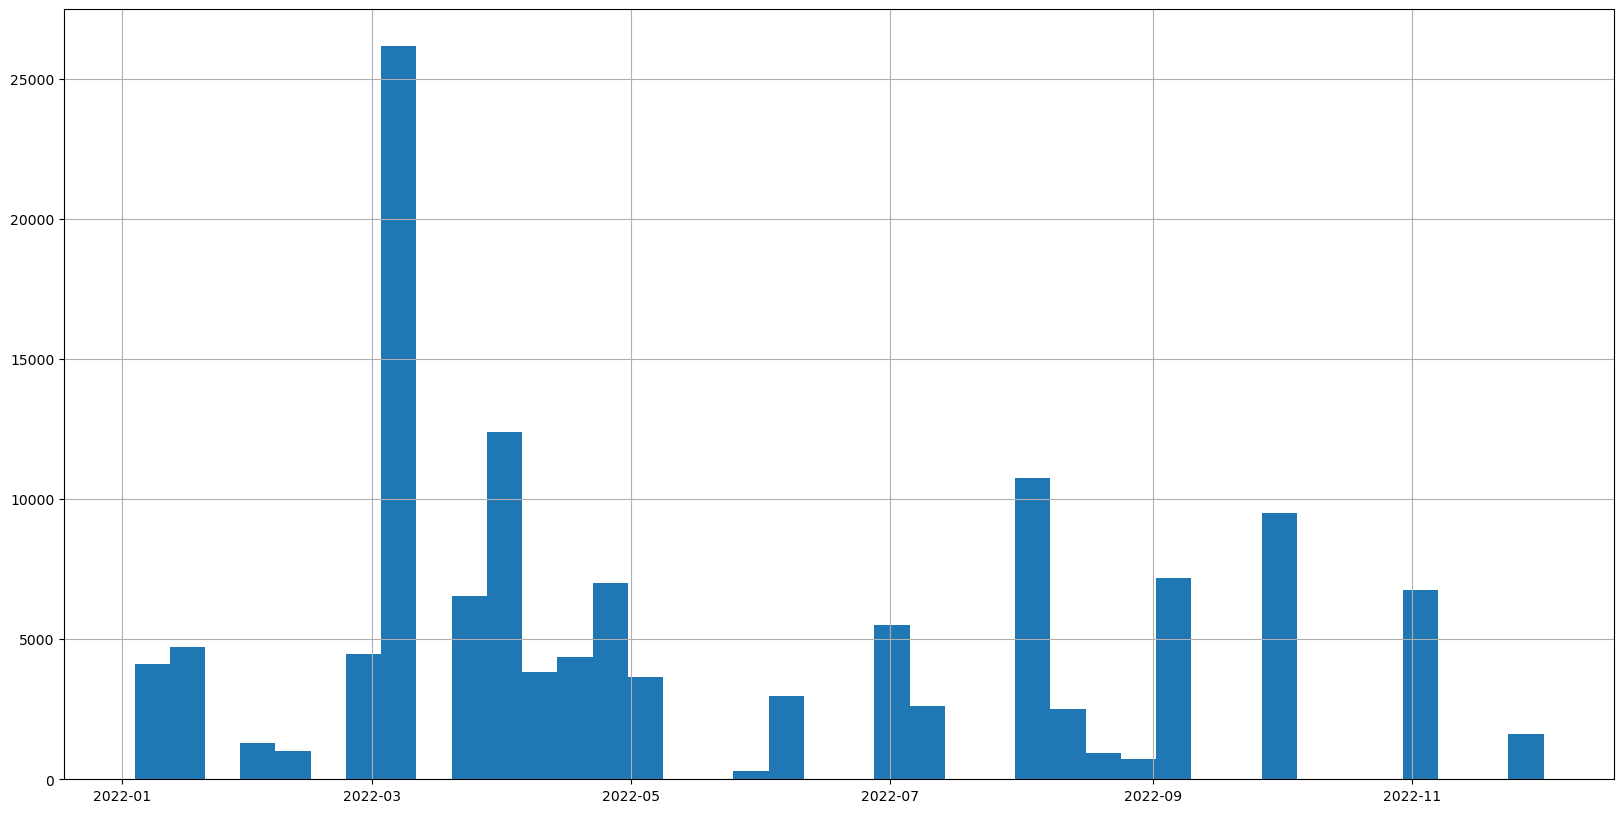

In [60]:
# check number of tweets over time

df["date"].hist(figsize=(20,10), bins=40)

In [61]:
# add moving average for plotting later
df["7day_rolling_avg"] = df["compound"].rolling(7).mean()

In [62]:
# add compound score to categorize into negative, neutral, and positive
df["comp_score"] = df["compound"].apply(lambda x: "pos" if x > 0 else ("neg" if x < 0 else "neu"))

In [63]:
df.head()

,date,user_name,text,neg,neu,pos,compound,year_month,7day_rolling_avg,comp_score
4,2022-08-20 23:59:00,PA Limited Late Models,#F1 DJ Myers wins @rockitpizzasubs Carl Billet...,0.047,0.817,0.136,0.5574,2022-08,NaN,pos
5,2022-08-20 23:58:00,FormulaMarket,Not sure what I was expecting but y’all are go...,0.081,0.919,0.000,-0.1957,2022-08,NaN,neg
6,2022-08-20 23:56:00,Philip Patston,#INDYCAR are just toy #f1 so it’s not very eng...,0.266,0.734,0.000,-0.5742,2022-08,NaN,neg
7,2022-08-20 23:53:00,Matt,@FDSportsbook Fanduel is the biggest scam. The...,0.159,0.656,0.184,0.2023,2022-08,NaN,pos
8,2022-08-20 23:52:00,FormulaRapida.net 🇬🇧 🇺🇸,Formula 1 drivers reflect on how the 2022 new ...,0.060,0.940,0.000,-0.1531,2022-08,NaN,neg


In [64]:
df.corr()

,neg,neu,pos,compound,7day_rolling_avg
neg,1.000000,-0.502083,-0.141437,-0.578423,-0.243583
neu,-0.502083,1.000000,-0.785111,-0.288860,-0.139134
pos,-0.141437,-0.785111,1.000000,0.744897,0.333712
compound,-0.578423,-0.288860,0.744897,1.000000,0.440972
7day_rolling_avg,-0.243583,-0.139134,0.333712,0.440972,1.000000


<AxesSubplot:>

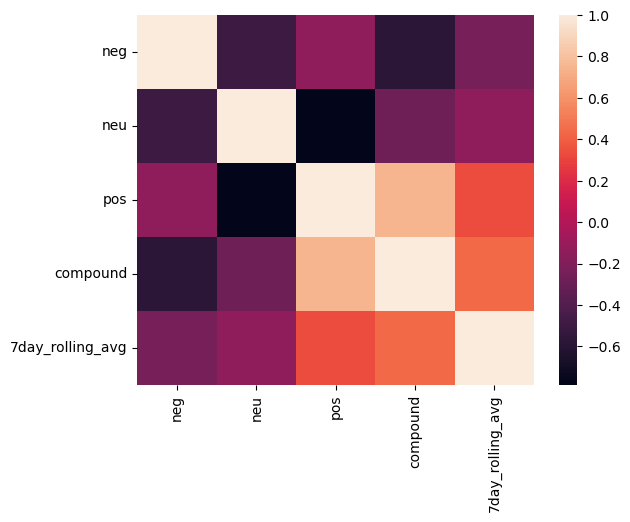

In [65]:
# check correlation
sns.heatmap(df.corr())

<AxesSubplot:>

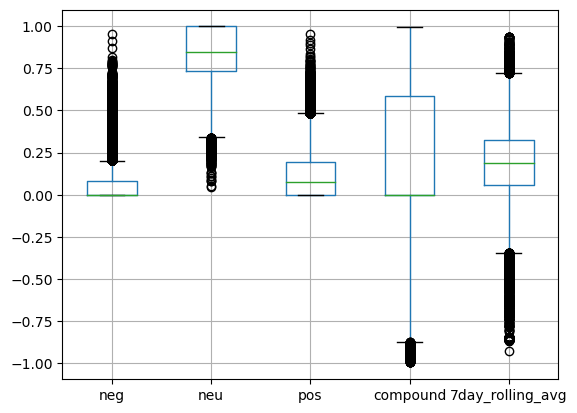

In [66]:
df.boxplot()

<AxesSubplot:ylabel='compound'>

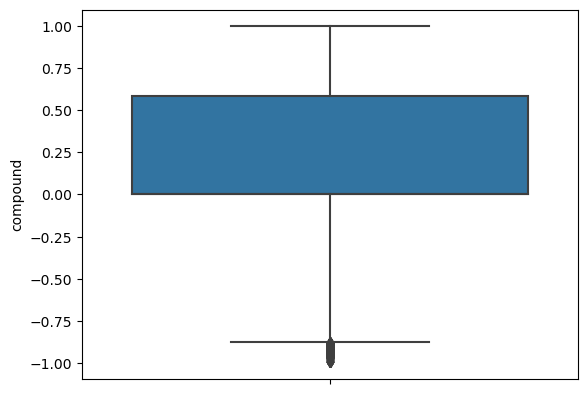

In [67]:
sns.boxplot(y=df["compound"])

<AxesSubplot:ylabel='compound'>

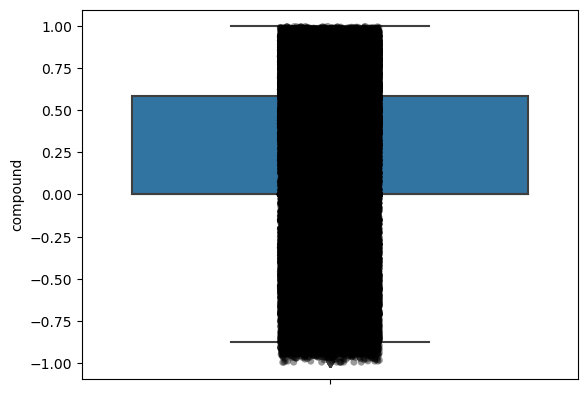

In [68]:
# check distribution of data points in compound columnn

sns.boxplot(y=df["compound"])
sns.stripplot(y=df["compound"], jitter=True, marker="o", alpha=0.4, color="black")

<AxesSubplot:>

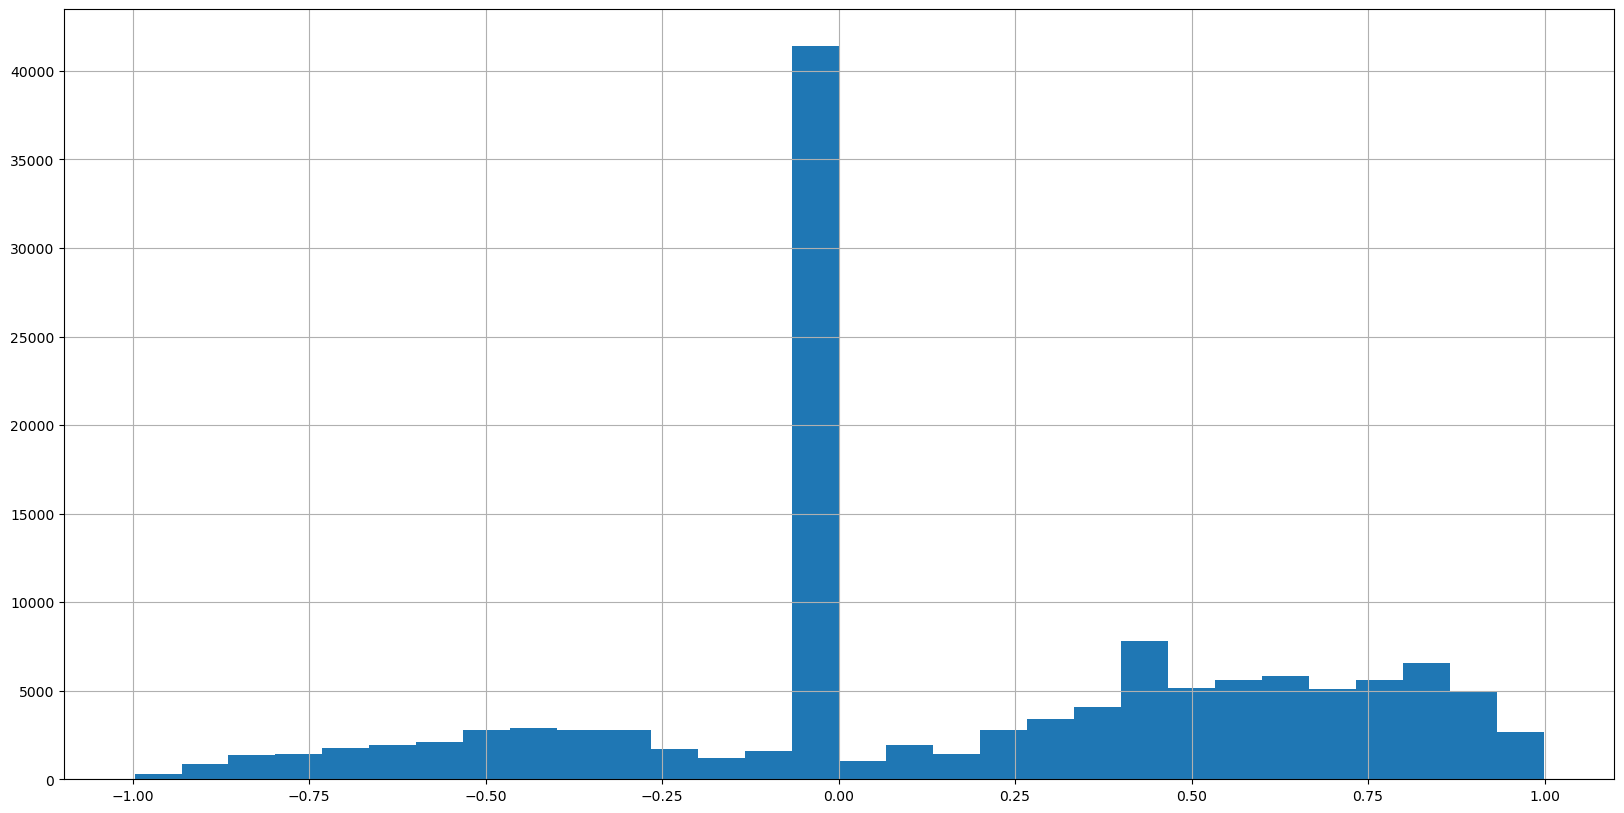

In [69]:
# check distribution of compound values from VADER
df["compound"].hist(bins=30, figsize=(20,10))

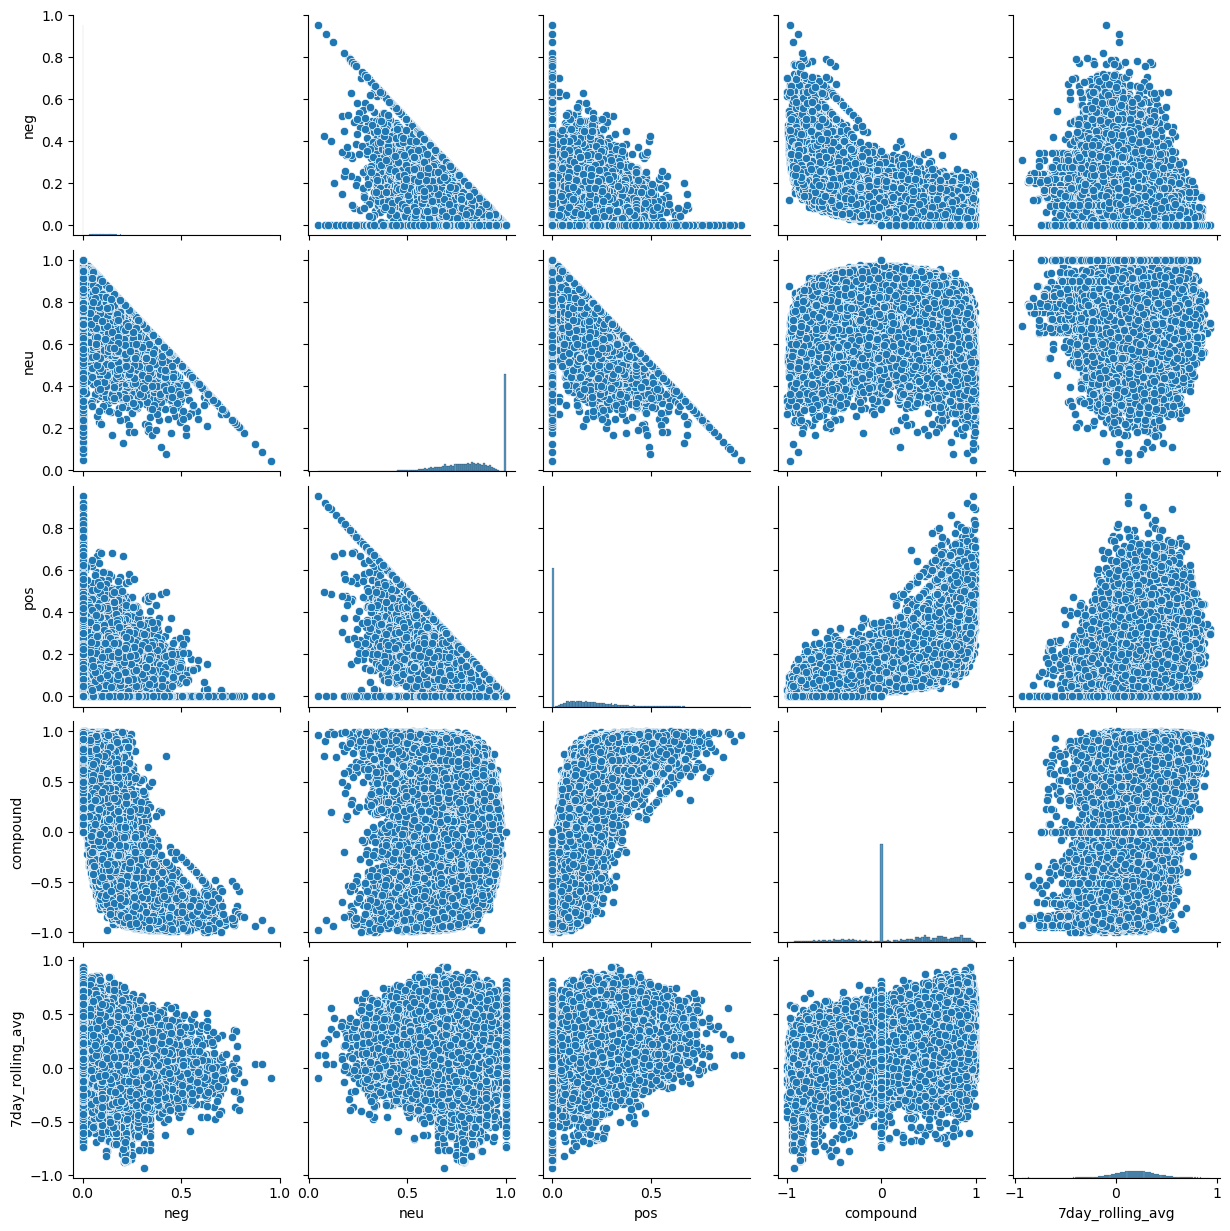

In [70]:
# perform pairplot analysis
sns.pairplot(df)

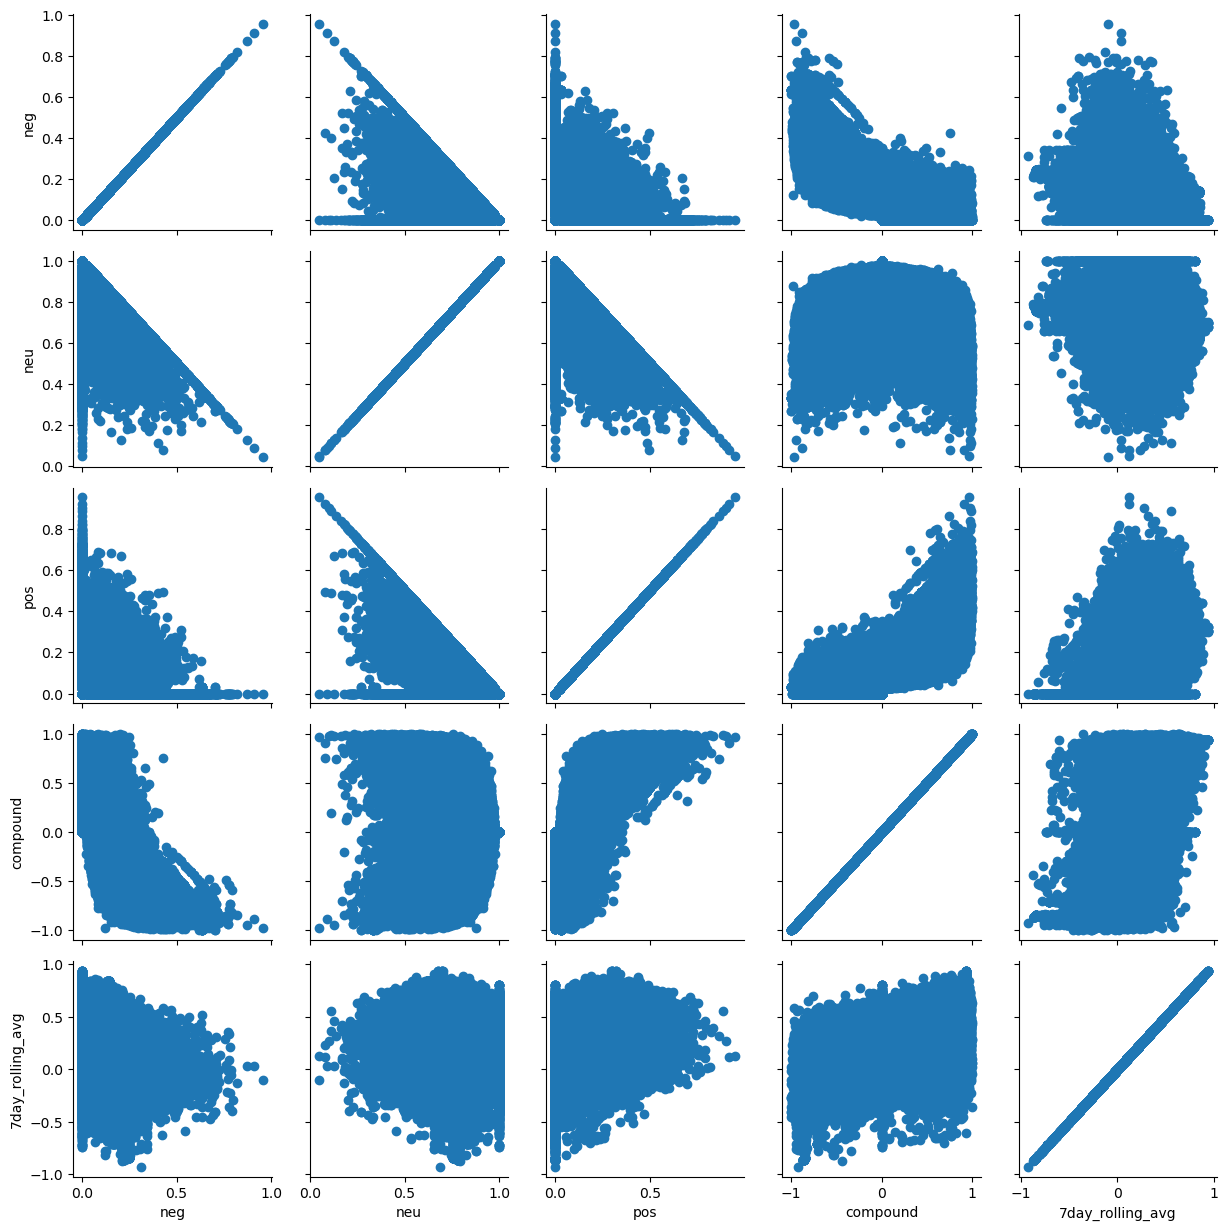

In [71]:
# check relationships and trends
g = sns.PairGrid(df)
g.map(plt.scatter)

# Conclusions and Visualizations

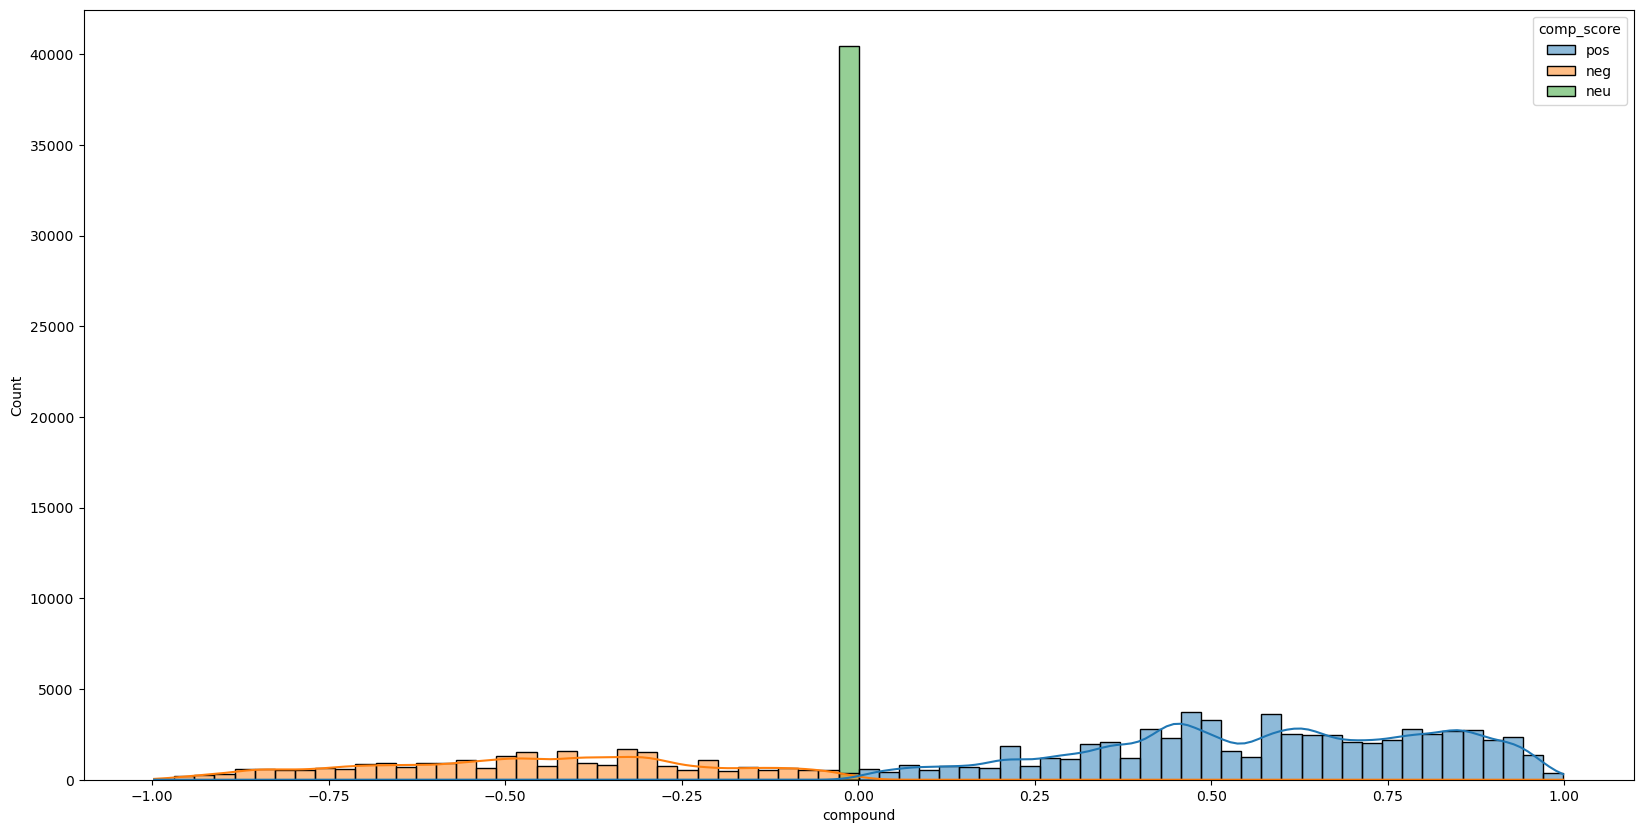

In [74]:
# generate histogram to show distribution of sentiment score
plt.figure(figsize=(20,10))
sns.histplot(data=df, x="compound", bins=70, kde=True, hue="comp_score")
plt.show()

The observation of a significant increase in sentiment scores concentrated around the neutral (0) to slightly positive (>0) range indicates that the overall perception of the public tends to be neutral to slightly positive.

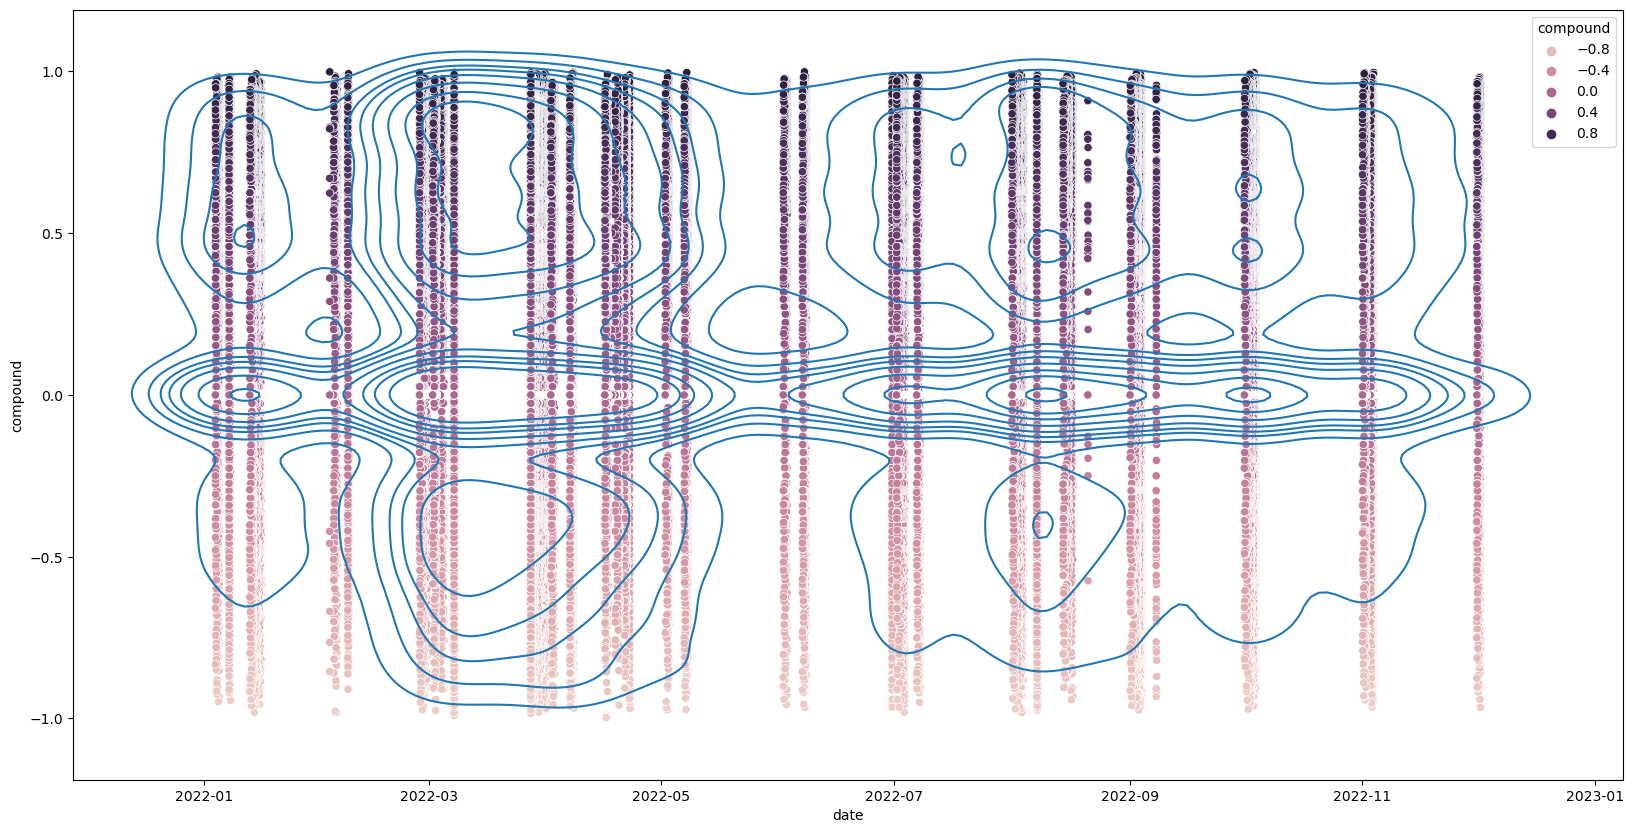

In [76]:
# generate scatterplot to show tweet's sentiment score over time
plt.figure(figsize=(20, 10))
sns.scatterplot(data=df, x="date", y="compound", hue="compound")
sns.kdeplot(x=df["date"], y=df["compound"])
plt.show()

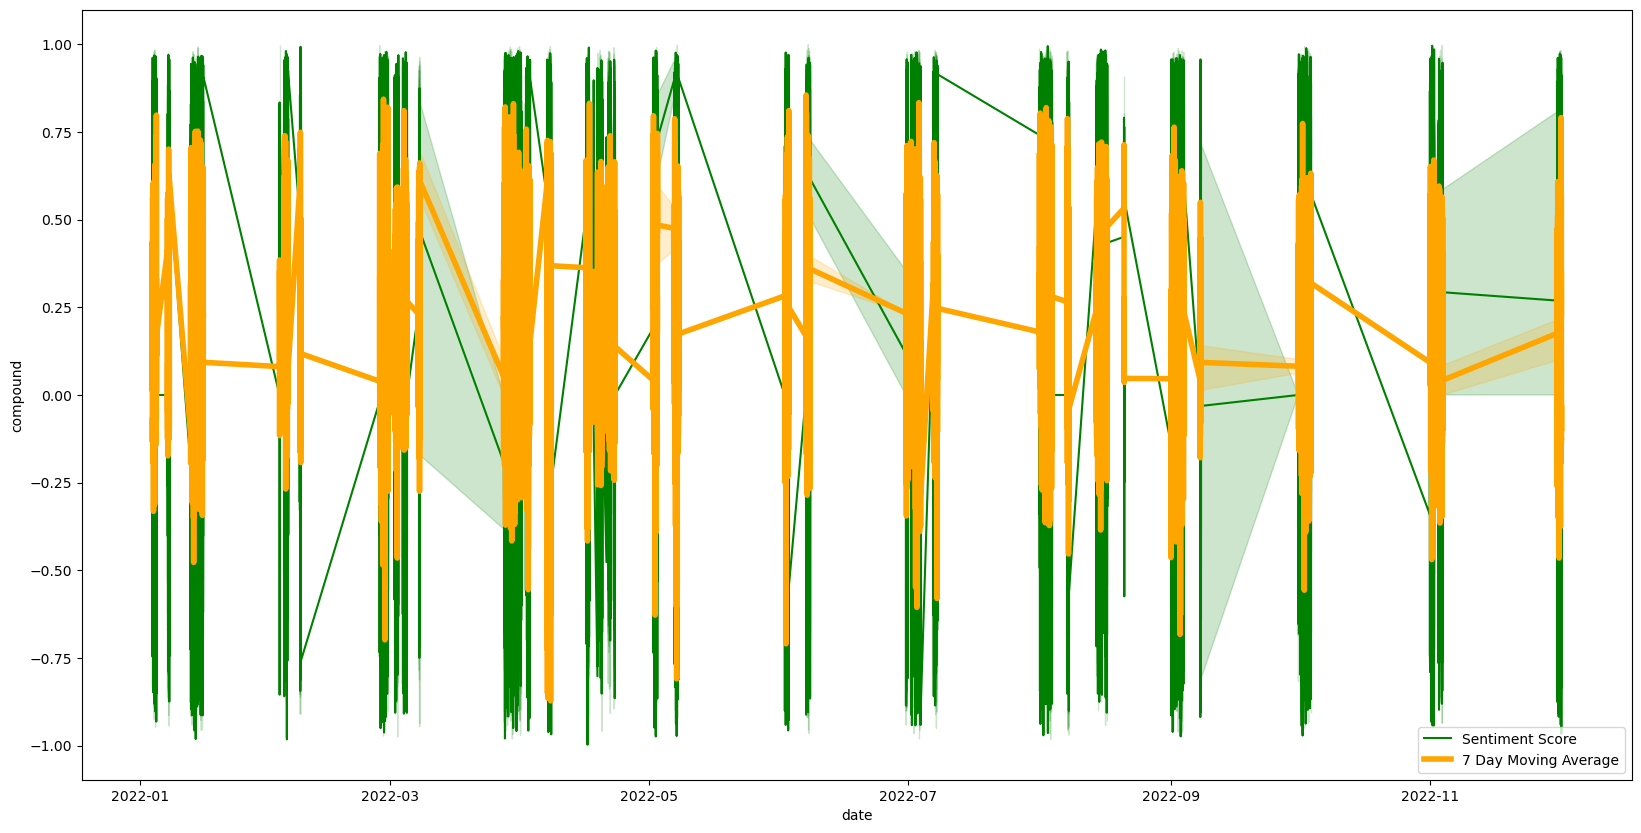

In [77]:
# visualize moving average over time
plt.figure(figsize=(20,10))
sns.lineplot(data=df, x="date", y="compound", label="Sentiment Score", color="green")
sns.lineplot(data=df, x="date", y="7day_rolling_avg", label="7 Day Moving Average", color="orange", linewidth=4)
plt.show()

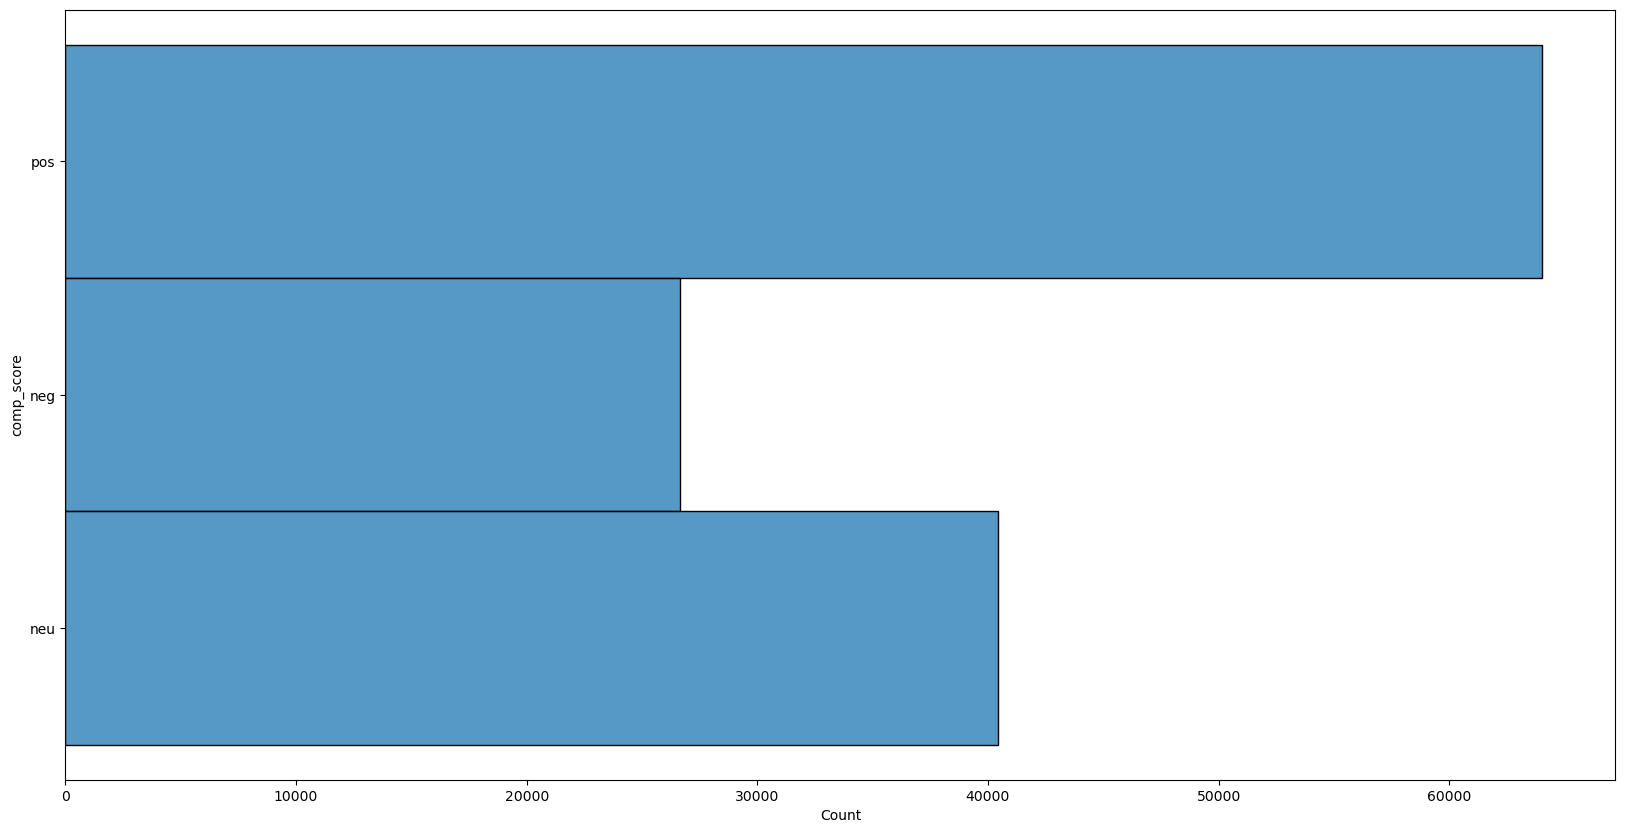

In [78]:
# show distribution of comp_score categories
plt.figure(figsize=(20,10))
sns.histplot(data=df, y="comp_score")
plt.show()

In [79]:
# calculate mean
df["compound"].mean()

0.18804375681924015

In [81]:
# split tweets into words for wordcloud
text = " ".join(t for t in df.text.astype(str))
print(f"There are {len(text)} words in the combination of all cells in column tweet.")

There are 19487227 words in the combination of all cells in column tweet.


In [82]:
# ignore stopwords that are frequently used
stopwords = set()
stopwords.update(["https", "co", "t", "gt", "i", "it", "a", "the", "but", "by", "my", "and", "in", "this", "all", "like", "will"
                 , "of", "as", "be", "is", "you", "their", "for", "so", "at", "just", "if", "me", "from", "now", "on", "to", "are"
                 , "what", "they", "an", "we", "here", "can", "with", "that", "have", "do"])

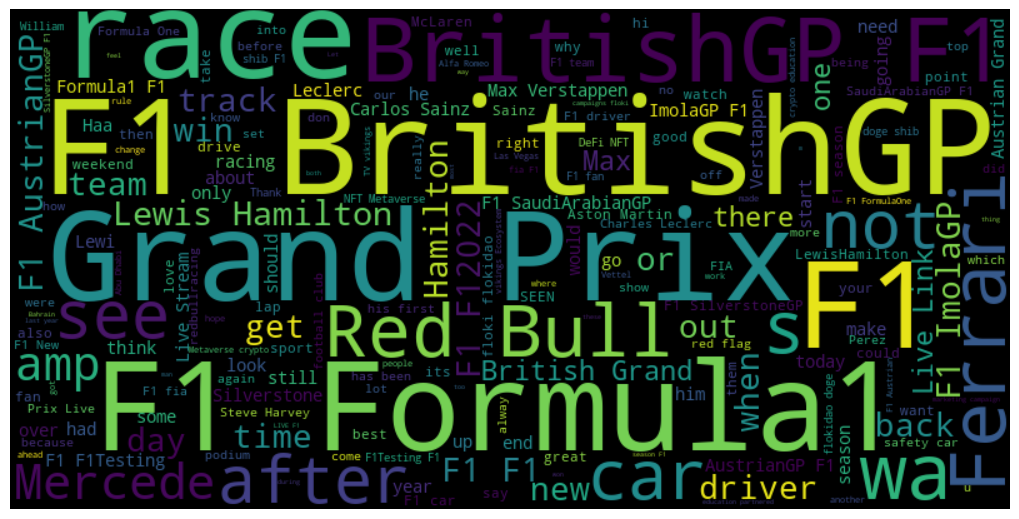

In [91]:
# create wordcloud object
wordcloud = WordCloud(stopwords=stopwords, background_color="black", width=800, height=400).generate(text)
fig, ax = plt.subplots(figsize=(10, 5))
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.show()

Among other renowned drivers such as Max Verstappen, Charles Leclerc, and Carlos Sainz, Sir Lewis Hamilton continues to dominate discussions as the most talked-about driver despite Max winning the championship in 2021. In terms of the most discussed cars, Ferrari takes the lead, followed by Red Bull and Mercedes. When it comes to races, the British Grand Prix and Silverstone hold the highest level of conversation, closely followed by the Australian Grand Prix.

# Conclusion

The analysis of sentiment scores for F1 in 2022 reveals that people generally hold positive and neutral sentiments towards the subject. This conclusion is drawn from the observation of sentiment scores clustering around positive values and a substantial proportion of scores falling within the neutral range. The collective sentiment expressed by individuals reflects a favorable outlook or a relatively balanced viewpoint regarding F1 in the year 2022. This finding suggests that the overall sentiment among the public towards F1 during this period is predominantly positive or at least neutral, indicating a generally favorable perception of the subject.